In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

## Clustering de semillas

In [6]:
SEED = 100495861

In [9]:
df = pd.read_csv('semillas.csv')
df.sample(5)

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
115,19.06,16.45,0.8854,6.416,3.719,2.248,6.163,2
84,19.51,16.71,0.8780,6.366,3.801,2.962,6.185,2
174,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,3
203,12.70,13.41,0.8874,5.183,3.091,8.456,5.000,3


In [11]:
df.describe()

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


A partir de este estudio simple, se puede identificar que:
- Existen un máximo de tres clases
- El resto de los datos son floats, se necesita una mayor investigación.
- 
Para comprobar los PCAs, debemos de sacar X e Y

In [19]:
X = df.drop(columns=["clase"])
y = df["clase"]

print(X.shape, X.columns)
print(y.shape)

(210, 7) Index(['area', 'perimetro', 'compacidad', 'longitud', 'anchura', 'asimetria',
       'surco'],
      dtype='object')
(210,)


## Comprobar los scalers

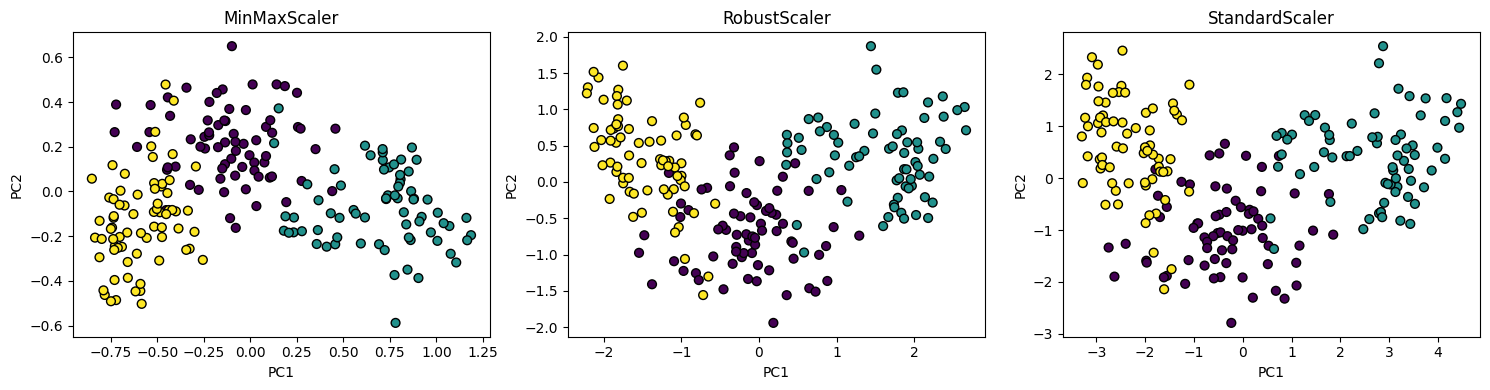

In [24]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

scalers = [MinMaxScaler(), RobustScaler(), StandardScaler()]
scaler_names = ["MinMaxScaler", "RobustScaler", "StandardScaler"]

plt.figure(figsize=(15, 4))

for i, (scaler, name) in enumerate(zip(scalers, scaler_names)):
    pipe = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_reduced = pipe.fit_transform(X)

    plt.subplot(1, 3, i + 1)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="viridis", edgecolor="k", s=40)
    plt.title(name)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.tight_layout()
plt.show()

Ojo avizor, parece que no hay mucha diferencia pero parece que con RobustScaler se encuentra todo mucho mejor agrupado que de normal. Tiraremos de ese hilo.